# Soil erosion detection

In [1]:
import rasterio
import rasterio.mask
from rasterio.plot import reshape_as_image, show
import matplotlib.pyplot as plt 
import geopandas as gpd

import fiona

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
with rasterio.open('T36UXV_20200406T083559_TCI_10m.jp2', 'r', driver = 'JP2OpenJPEG') as src:
    raster_img = src.read()
    raster_meta = src.meta

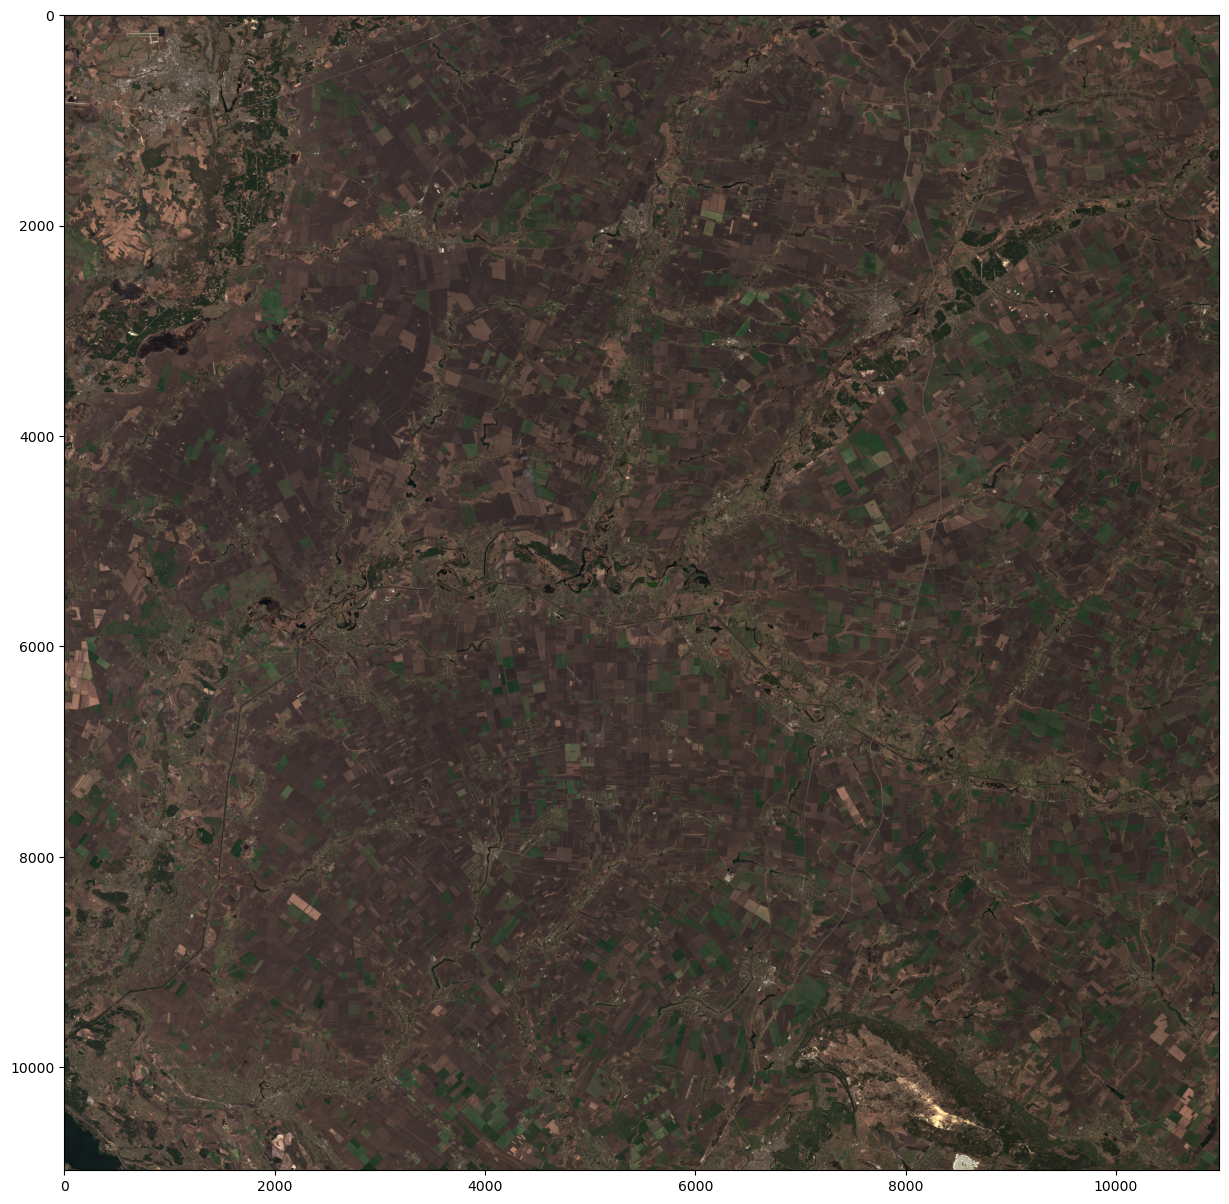

In [3]:
raster_img = reshape_as_image(raster_img)

plt.figure(figsize = (15,15))
plt.imshow(raster_img)

In [4]:
df = gpd.read_file('masks/Masks_T36UXV_20190427.shp')
df.head(4)

,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."


In [5]:
# let's remove rows without geometry
df.id = range(len(df))
df = df[df.geometry.notnull()]
df = df.drop(columns = ['Data', 'Image'])
df.head(4)

,id,Code,Descriptio,Comments,geometry
0,0,2.0,branch of tree,None,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,1,1.0,color+ feathers,None,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,2,2.0,brahch of tree,None,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,3,1.0,color+ feathers,None,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."


In [6]:
print('Shape file Projection: ', df.crs)
print('Imagery file Projection: ', src.crs)

Shape file Projection:  epsg:4326
Imagery file Projection:  EPSG:32636


In [7]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open('T36UXV_20200406T083559_TCI_10m.jp2') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('trans_im.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)                

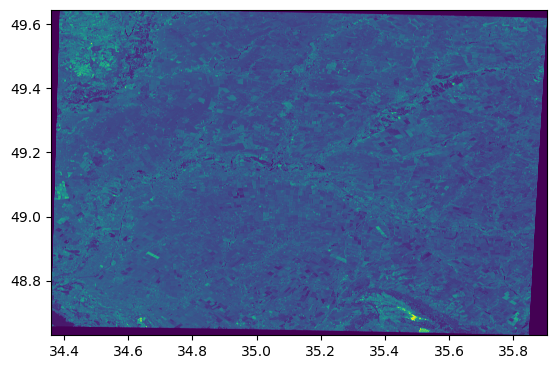

<AxesSubplot: >

In [8]:
tr_imagery = rasterio.open("trans_im.jp2")
# Plot trasformed imagery
show(tr_imagery)

In [11]:
with rasterio.open('trans_im.jp2', 'r', driver = 'JP2OpenJPEG') as src:
    im = src.read()

im = reshape_as_image(im)

In [13]:
M = im.shape[0]//69
N = im.shape[1]//105

In [14]:
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

In [31]:
with rasterio.open('mask.tif', 'r') as src:
    sh = src.read()

sh = reshape_as_image(sh)

In [18]:
M = sh.shape[0]//69
N = sh.shape[1]//105

In [20]:
tiles_sh = [sh[x:x+M,y:y+N] for x in range(0,sh.shape[0],M) for y in range(0,sh.shape[1],N)]

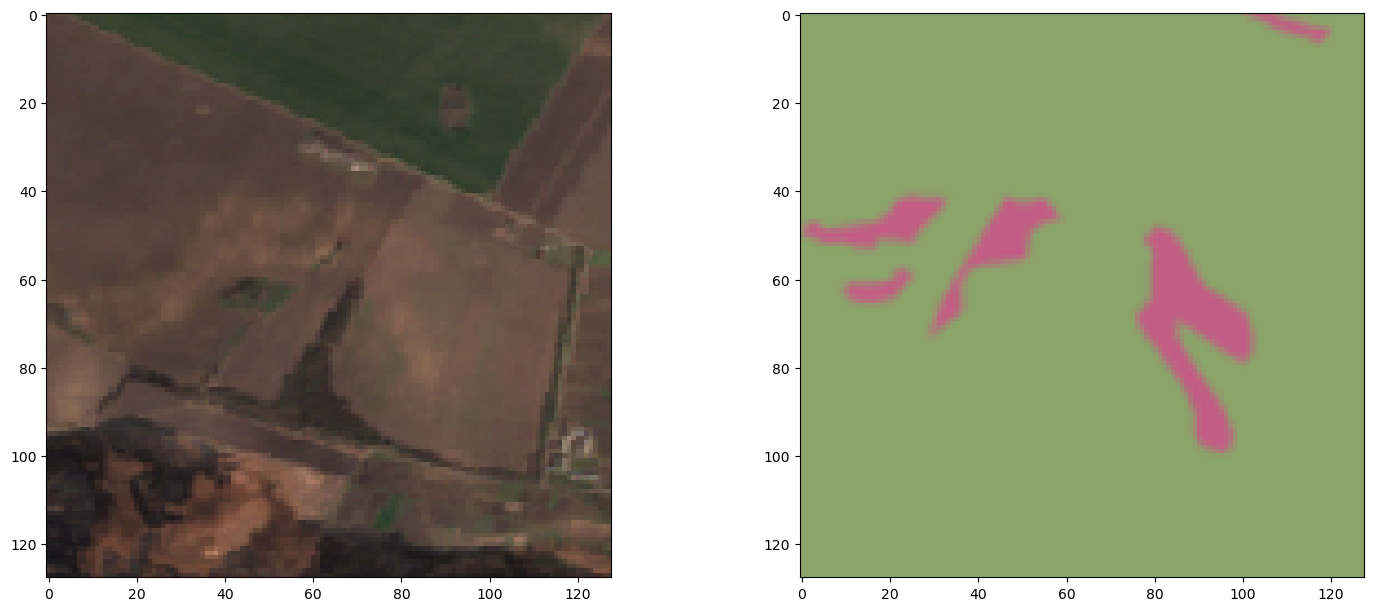

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
axs[0].imshow(tiles[108])
axs[1].imshow(tiles_sh[108])

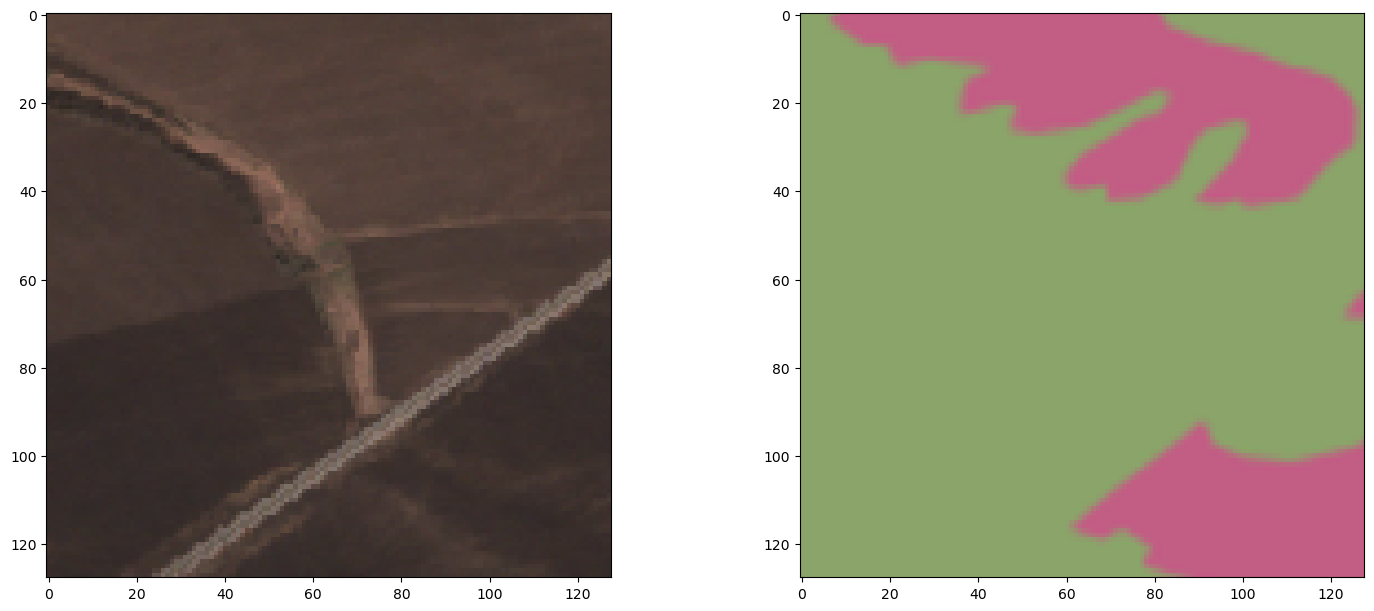

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
axs[0].imshow(tiles[396])
axs[1].imshow(tiles_sh[396])

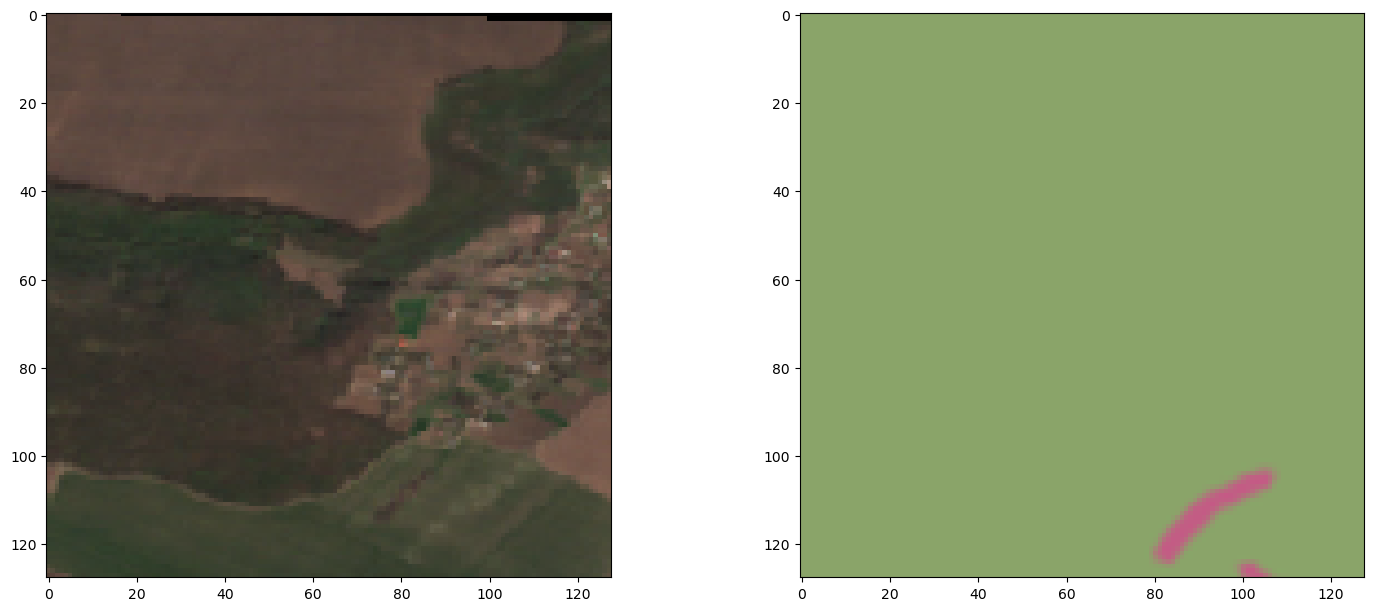

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
axs[0].imshow(tiles[2])
axs[1].imshow(tiles_sh[2])

In [137]:
import os
import cv2
from PIL import Image

outfolder_t = "tiles"
outfolder_sh = 'tiles_sh'
outfolder_t_t = "tiles_test"

maxcolors = 100000

os.makedirs(outfolder_t, exist_ok=True)
os.makedirs(outfolder_sh, exist_ok=True)
os.makedirs(outfolder_t_t, exist_ok=True)

for i in range(len(tiles)):
    if tiles[i].shape[0] == 128 and tiles[i].shape[1] == 128:
        im_sh = Image.fromarray(tiles_sh[i]).convert('RGB')
        if len(im_sh.getcolors(1000)) >= 5:
            im_t = Image.fromarray(tiles[i])
            if im_t.getcolors(100000)[-1][1] == (0, 0, 0): 
                if im_t.getcolors(100000)[-1][0] <= 2500:
                    im_sh.save(outfolder_sh + '/' + str(i)+'.png')
                    im_t.save(outfolder_t + '/' + str(i)+'.jpg')
            else:
                im_sh.save(outfolder_sh + '/' + str(i)+'.png')
                im_t.save(outfolder_t + '/' + str(i)+'.jpg')
        else:
            im_t = Image.fromarray(tiles[i])
            if im_t.getcolors(100000)[-1][1] != (0, 0, 0): 
                im_t.save(outfolder_t_t + '/' + str(i)+'.jpg')
        
        